# Import Packages

In [34]:
# Import all the requisite packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

# Read Dataset

In [35]:
# Load all the dataset 
uamn = pd.read_csv("t1_user_active_min.csv")
usv = pd.read_csv("t2_user_variant.csv")
uamp = pd.read_csv("t3_user_active_min_pre.csv")
uatt = pd.read_csv("t4_user_attributes.csv")

# Basic Explorations

In [36]:
# See the head to view contents of the dataset 
uamn.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [98]:
# Get min and max date
uamn.dt.min(),uamn.dt.max()

('2019-02-06', '2019-07-05')

In [38]:
# Get count of unique user ids 
uamn.uid.nunique()

46633

In [39]:
uamn.describe()

,uid,active_mins
count,1.066402e+06,1.066402e+06
mean,2.422100e+04,3.616809e+01
std,1.417358e+04,1.270484e+03
min,0.000000e+00,1.000000e+00
25%,1.202000e+04,2.000000e+00
50%,2.394100e+04,5.000000e+00
75%,3.618100e+04,1.700000e+01
max,4.999900e+04,9.999900e+04


In [40]:
#See head of the dataset of the control group 
usv.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [41]:
# Get unique count of the user ids and intersection across two tables 
usv.uid.nunique(), len(set(usv.uid.unique()).intersection(set(uamn.uid.unique())))

(50000, 46633)

In [71]:
# Get control group counts 
usv['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

In [43]:
#See previous user history data 
uamp.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [20]:
# Min and Max date duration for previous user history data 
uamp.dt.min(),uamp.dt.max()

('2018-08-10', '2019-02-05')

In [21]:
# User profiling data
uatt.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [22]:
# Distribution of gender 
uatt.gender.value_counts()

male       27757
female     14477
unknown     7766
Name: gender, dtype: int64

In [23]:
uatt.user_type.value_counts()

non_reader     36066
reader          8002
new_user        4888
contributor     1044
Name: user_type, dtype: int64

# Outlier Removal

In [33]:
# Identifying outliers
# Step 1: Remove all people who have data entry errors 
# Step 2: Remove the outliers according to the outlier criterions
max_min_daily  = 24*60
print("Rows as outliers: ",uamn[uamn['active_mins']>=max_min_daily].shape[0])
uamn_rem_out = uamn[uamn['active_mins']<=max_min_daily].reset_index(drop=True)

Rows as outliers:  172


In [46]:
uamn_rem_out['active_mins'].describe()

count    1.066230e+06
mean     2.004248e+01
std      4.653763e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      8.970000e+02
Name: active_mins, dtype: float64

C:\Users\nishant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='active_mins'>

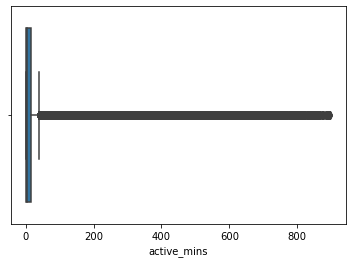

In [45]:
# Also, there is little possibility that the user is glued to Quora for 24 hours of the entire day, so we use standard technique of outlier removal 
# Removing using 1.5*IQR rule 
sns.boxplot(uamn_rem_out['active_mins'])

In [50]:
#Get Q1 and Q3 for IQR  
q1 = uamn_rem_out['active_mins'].quantile(0.25)
q3 = uamn_rem_out['active_mins'].quantile(0.75)

In [88]:
# Get stats for lower quartile range 
# Remove the IQR based outliers
print("Users in lower strata:" , uamn_rem_out[uamn_rem_out['active_mins']<q1-1.5*(q3-q1)]['uid'].nunique())
# Get stats for upto an upper quartile range
uamn_rem_out[uamn_rem_out['active_mins']<=q3+1.5*(q3-q1)].shape
# Filter the results to remove all possible outliers
uamn_final = uamn_rem_out[uamn_rem_out['active_mins']<q3+1.5*(q3-q1)].reset_index(drop=True)
uamn_final.shape,uamn.shape

Users in lower strata: 0


((931953, 3), (1066402, 3))

In [89]:
# Merge to extract the variant group in same table as t1
activ_var = uamn_final.merge(usv,how='left',left_on='uid',right_on='uid')

In [90]:
activ_var.head()

,uid,dt_x,active_mins,variant_number,dt_y,signup_date
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24


In [171]:
# Check if there are any null values 
activ_var.isnull().sum()

uid               0
dt_x              0
active_mins       0
variant_number    0
dt_y              0
signup_date       0
dtype: int64

In [161]:
# Take mean at user level and control/uncontrolled variant level and create a DataFrame 
agg_activ = activ_var.groupby(['uid','variant_number'])['active_mins'].mean().reset_index()

In [162]:
# Check if all the users have some activity or not 
agg_activ[(agg_activ['active_mins']==0)&(agg_activ['variant_number']==1)]['uid'].nunique()

0

In [163]:
# Install pingouin package for performing statistical tests for the two groups 
#!pip install pingouin --user

# Check for Normal Assumption throgh figures for t-test

In [164]:
import pingouin as pg

In [165]:
# Seggregate data of the two control groups 
control_a = agg_activ[agg_activ['variant_number']==0].reset_index(drop=True)
control_b = agg_activ[agg_activ['variant_number']==1].reset_index(drop=True)

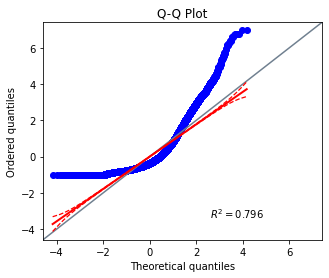

In [166]:
# Check if the distribution is close to normal or not (Q-Q plot should have R2 close to 1)
ax = pg.qqplot(agg_activ['active_mins'], dist='norm')
# Distribution below does seem to be close to normal roughly (R2 ~0.8)

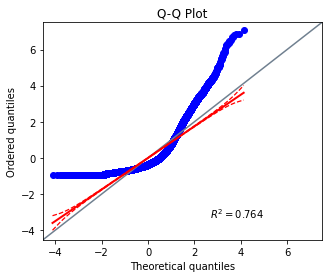

In [167]:
ax = pg.qqplot(control_a['active_mins'], dist='norm')

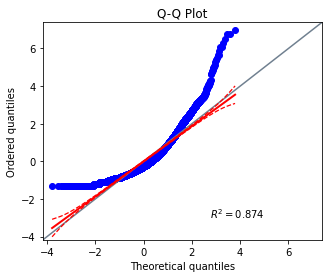

In [168]:
ax = pg.qqplot(control_b['active_mins'], dist='norm')

In [169]:
control_a['uid'].count()

37408

# T-Test Calculation Code and Method

In [177]:
# Formula for calculating the df and t-statistics 
# Link: https://trendingsideways.com/the-p-value-formula-testing-your-hypothesis

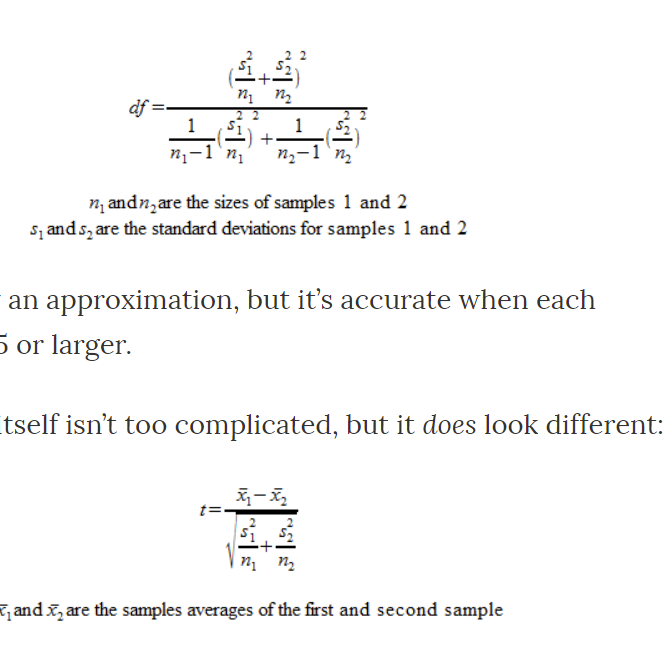

In [180]:
# We need a way to calculate 95% confidence interval for inferring the difference in average 
# Perform t-tests (this would be Welch test as mean and std dev across the two samples are quite different)
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd
# Levereged Code from https://stats.stackexchange.com/questions/475289/confidence-interval-for-2-sample-t-test-with-scipy
def welch_ttest(x1, x2):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

# Experiment for Present Time Period (Control and Experiment Group)

In [183]:
# Perform Welch test
welch_ttest(control_b['active_mins'],control_a['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,29.6781,14387.767137,6.407844e-188,1.549165,1.446849,1.651482


In [184]:
# Perform t-tests (this would be Welch test as mean and std dev across the two samples are quite different)
# Check the above p-value using the scipy implementation of the welch t-test
import scipy 
scipy.stats.ttest_ind_from_stats(control_b['active_mins'].mean(),control_b['active_mins'].std(),control_b['uid'].count(),control_a['active_mins'].mean(),control_a['active_mins'].std(),control_a['uid'].count(),equal_var=False)

Ttest_indResult(statistic=29.678099734105686, pvalue=6.407844074258002e-188)

In [ ]:
# Note that the above results indicate that the p-values are less than 0.05 and hence we can reject the null hypothesis 

C:\Users\nishant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='variant_number', ylabel='active_mins'>

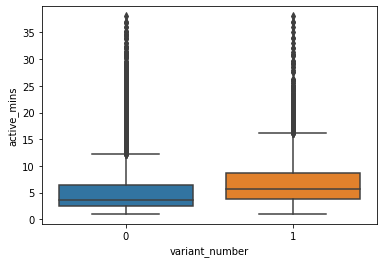

In [185]:
sns.boxplot(agg_activ['variant_number'],agg_activ['active_mins'])

In [187]:
# We deep dive into the analysis by comparing the user behavior changes historically 
# We now change the definition of our control group and treatment group. 
# The treatment group remains post-period timeline customers where "variant_number=1"
# We assign the users in previous history a "variant_number=0"

In [188]:
uamp.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


# Experiment Checks for Previous Time Period

In [196]:
# agg_uamp = uamp.groupby(['uid'])['active_mins'].sum().reset_index()
# Remove the cases with outliers and greater than q3+1.5*IQR
max_min_daily  = 24*60
print("Rows as outliers: ",uamp[uamp['active_mins']>=max_min_daily].shape[0])
uamp_rem_out = uamp[uamp['active_mins']<=max_min_daily].reset_index(drop=True)

#Get Q1 and Q3 for IQR  
q1 = uamp_rem_out['active_mins'].quantile(0.25)
q3 = uamp_rem_out['active_mins'].quantile(0.75)

# Get stats for lower quartile range 
# Remove the IQR based outliers
print("Users in lower strata:" , uamp_rem_out[uamp_rem_out['active_mins']<q1-1.5*(q3-q1)]['uid'].nunique())
# Get stats for upto an upper quartile range
uamp_rem_out[uamp_rem_out['active_mins']<=q3+1.5*(q3-q1)].shape
# Filter the results to remove all possible outliers
uamp_final = uamp_rem_out[uamp_rem_out['active_mins']<q3+1.5*(q3-q1)].reset_index(drop=True)
uamp_final.shape,uamp.shape

Rows as outliers:  166
Users in lower strata: 0


((1024286, 3), (1190093, 3))

In [208]:
# Groupby across the time period to get the aggregate value of the active minutes 
agg_uamp = uamp_final.groupby(['uid'])['active_mins'].mean().reset_index()
# Assign all the user ids in the previous history as having a "0" treatment group for comparison with "1" treatment group 
agg_uamp['variant_number']=0
# # Subset for the same set of users 
# agg_uamp_final = agg_uamp[agg_uamp['uid'].isin(control_b['uid'].unique().tolist())].reset_index()

### Test 2.1: Compare Experimental Group with Previous Control Group 

In [209]:
# Perform Welch test
welch_ttest(control_b['active_mins'],agg_uamp['active_mins'])
# This indicates that introduction of feature has played a significant effect over time

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,38.828262,11506.991758,5.017540e-310,1.910005,1.813582,2.006428


### Test 2.2: Compare Present Control Group with Previous Control Group 

In [215]:
# Now we only need to check one final hypothesis, that the changes are not due to the time that has passed 
# and rather due to the new feature introduction. This can be done by performing a t-test over the "0" control group across 
# two time period 
welch_ttest(control_a['active_mins'],agg_uamp['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,12.571107,68755.518627,3.337039e-36,0.36084,0.30458,0.417099


In [214]:
# Ideally we would have been better if the p-value would have supported the null hypothesis and from above we see that 
# null hypothesis is rejected which means across the control group where changes were not introduced,
# user interactivity has increased even without introduction of the change. So, it would be very difficult to 
# say conclusively if the change was truely due to the introduction of new feature or due to the time factor. 
# But since we see that the lb and ub values are lowered in comparison to prev experiment, effect of time is definitely lesser

# But since both the factors, introduction of feature (comparison on present level across two groups) and time support 
# and lead to the increase in engagement, we can recommend to roll out new features

In [220]:
# User interactivity across two time period for zero control group
# Concat two DataFrames
agg_uamp['time_period']='past'
control_a['time_period']='present_test'
past_present_data = pd.concat([control_a,agg_uamp],axis=0).reset_index(drop=True)

C:\Users\nishant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_period', ylabel='active_mins'>

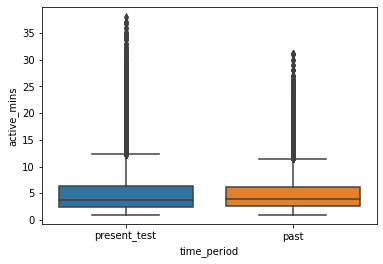

In [221]:
sns.boxplot(past_present_data['time_period'],past_present_data['active_mins'])

In [223]:
control_a['active_mins'].describe()

count    37408.000000
mean         5.367573
std          4.595056
min          1.000000
25%          2.444444
50%          3.666667
75%          6.384615
max         38.000000
Name: active_mins, dtype: float64

In [224]:
agg_uamp['active_mins'].describe()

count    49643.000000
mean         5.006734
std          3.589021
min          1.000000
25%          2.600000
50%          3.833333
75%          6.165612
max         31.000000
Name: active_mins, dtype: float64

In [225]:
control_b['active_mins'].describe()

count    9197.000000
mean        6.916739
std         4.457375
min         1.000000
25%         3.800000
50%         5.750000
75%         8.735294
max        38.000000
Name: active_mins, dtype: float64

### Test 2.3: Compare (Control+Experimental Group of Present Data) with Previous Control Group 

In [226]:
# Changes on overall data
welch_ttest(agg_activ['active_mins'],agg_uamp['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,24.92067,87989.80583,1.326860e-136,0.666551,0.614127,0.718975


In [227]:
# Let's analyse the impact of other covariates 

In [228]:
agg_activ.head()

,uid,variant_number,active_mins
0,0,0,3.307692
1,1,0,19.800000
2,2,0,2.428571
3,3,0,3.208333
4,4,0,1.950000


In [229]:
uatt.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


# Merger to Create Overall Data 

In [233]:
att_data = agg_activ.merge(uatt,how='left',on='uid')
att_data.head()

,uid,variant_number,active_mins,gender,user_type
0,0,0,3.307692,male,non_reader
1,1,0,19.800000,male,reader
2,2,0,2.428571,male,non_reader
3,3,0,3.208333,male,non_reader
4,4,0,1.950000,male,non_reader


In [235]:
att_data['gender'].unique(),att_data['user_type'].unique()

(array(['male', 'female', 'unknown'], dtype=object),
 array(['non_reader', 'reader', 'new_user', 'contributor'], dtype=object))

In [240]:
att_data.shape

(46605, 5)

In [244]:
att_data[(att_data['variant_number']==1)&(att_data['gender']=='male')].reset_index(drop=True)

,uid,variant_number,active_mins,gender,user_type
0,40000,1,8.333333,male,new_user
1,40001,1,9.343750,male,non_reader
2,40002,1,7.038462,male,non_reader
3,40008,1,8.970588,male,non_reader
4,40011,1,12.750000,male,non_reader
...,...,...,...,...,...
5126,49991,1,21.000000,male,new_user
5127,49992,1,4.173913,male,non_reader
5128,49993,1,5.608696,male,non_reader
5129,49996,1,12.000000,male,non_reader


# Experiments for Comparisons Across Attributes 

In [245]:
# Comparison Across "Male" group
dmale_tr = att_data[(att_data['variant_number']==1)&(att_data['gender']=='male')].reset_index(drop=True)
dmale_co = att_data[(att_data['variant_number']==0)&(att_data['gender']=='male')].reset_index(drop=True)
welch_ttest(dmale_tr['active_mins'],dmale_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,20.597435,8225.519605,5.882002e-92,1.479446,1.338647,1.620244


In [247]:
# Comparison Across "Female" group
dgen_tr = att_data[(att_data['variant_number']==1)&(att_data['gender']=='female')].reset_index(drop=True)
dgen_co = att_data[(att_data['variant_number']==0)&(att_data['gender']=='female')].reset_index(drop=True)
welch_ttest(dgen_tr['active_mins'],dgen_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,16.574324,3983.963748,1.023208e-59,1.539559,1.357446,1.721672


In [250]:
# Comparison Across "Unknown" group
dgen_tr = att_data[(att_data['variant_number']==1)&(att_data['gender']=='unknown')].reset_index(drop=True)
dgen_co = att_data[(att_data['variant_number']==0)&(att_data['gender']=='unknown')].reset_index(drop=True)
welch_ttest(dgen_tr['active_mins'],dgen_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,14.298571,2132.614077,2.343912e-44,1.833367,1.581917,2.084817


In [252]:
# Comparison Across "Non-reader" group
ut_tr = att_data[(att_data['variant_number']==1)&(att_data['user_type']=='non_reader')].reset_index(drop=True)
ut_co = att_data[(att_data['variant_number']==0)&(att_data['user_type']=='non_reader')].reset_index(drop=True)
welch_ttest(ut_tr['active_mins'],ut_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,47.808654,9203.179559,0.0,2.034637,1.951214,2.11806


In [253]:
# Comparison Across "Reader" group
ut_tr = att_data[(att_data['variant_number']==1)&(att_data['user_type']=='reader')].reset_index(drop=True)
ut_co = att_data[(att_data['variant_number']==0)&(att_data['user_type']=='reader')].reset_index(drop=True)
welch_ttest(ut_tr['active_mins'],ut_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,10.161051,1883.925853,1.189653e-23,1.647241,1.3293,1.965181


In [254]:
# Comparison Across "Reader" group
ut_tr = att_data[(att_data['variant_number']==1)&(att_data['user_type']=='new_user')].reset_index(drop=True)
ut_co = att_data[(att_data['variant_number']==0)&(att_data['user_type']=='new_user')].reset_index(drop=True)
welch_ttest(ut_tr['active_mins'],ut_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,14.105064,981.66877,2.831940e-41,2.291112,1.972358,2.609865


In [255]:
# Comparison Across "Contributor" group
ut_tr = att_data[(att_data['variant_number']==1)&(att_data['user_type']=='contributor')].reset_index(drop=True)
ut_co = att_data[(att_data['variant_number']==0)&(att_data['user_type']=='contributor')].reset_index(drop=True)
welch_ttest(ut_tr['active_mins'],ut_co['active_mins'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-1.415615,176.226064,0.158653,-0.784466,-1.878093,0.309162


# Plots for Variation of Attribtes among Control and Experiment Group 

C:\Users\nishant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Variation of User Activity wrt to User Type for Control (Blue) and Experimental Groups (Orange)')

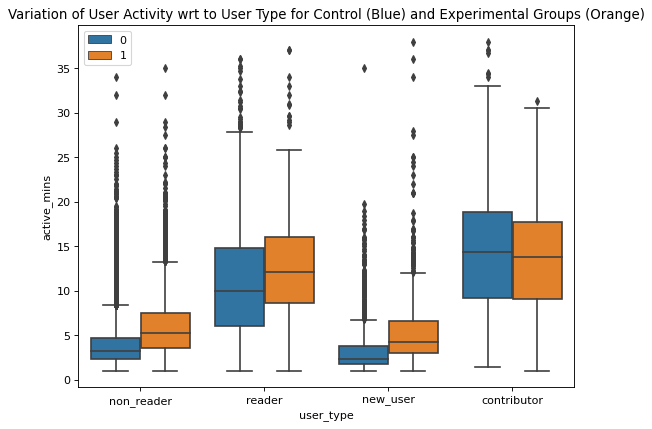

In [266]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
sns.boxplot(att_data['user_type'],att_data['active_mins'],hue=att_data['variant_number'])
plt.legend(loc='upper left')
plt.title("Variation of User Activity wrt to User Type for Control (Blue) and Experimental Groups (Orange)")

C:\Users\nishant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Variation of User Activity wrt to Gender for Control (Blue) and Experimental Groups (Orange)')

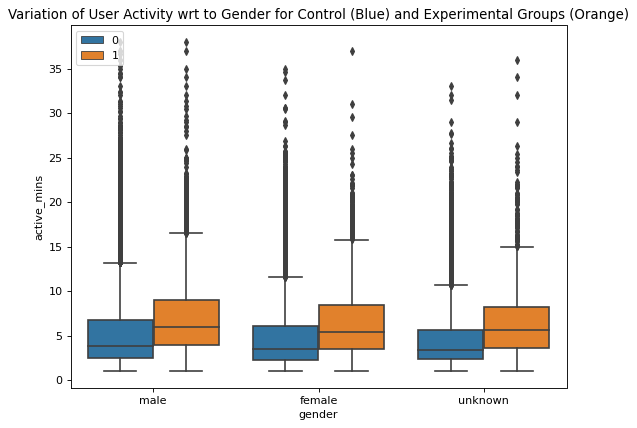

In [267]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
sns.boxplot(att_data['gender'],att_data['active_mins'],hue=att_data['variant_number'])
plt.legend(loc='upper left')
plt.title("Variation of User Activity wrt to Gender for Control (Blue) and Experimental Groups (Orange)")